# Complete random movements on environment


In [84]:
import gym
import gym_examples
import numpy as np

env = gym.make('gym_examples/GridWorld-v0', size=4)

state = env.reset()
agent_location = env.get_agent_location()
target_location = env.get_target_location()
print(f"Agent's INITIAL Location: {agent_location}, Target Location: {target_location}")

done = False


while not done:
    # Select action randomly
    action = env.action_space.sample()
    
    # take step, returns transition
    next_state, reward, done, truncated, info = env.step(action)
    
    agent_location = env.get_agent_location()
    target_location = env.get_target_location()
    print(f"Agent's Location: {agent_location}, Target Location: {target_location}")

    #update state
    state = next_state

env.close()

print("Episode finished")


Agent's INITIAL Location: [3 0], Target Location: [0 0]
Agent's Location: [3 0], Target Location: [0 0]
Agent's Location: [2 0], Target Location: [0 0]
Agent's Location: [2 1], Target Location: [0 0]
Agent's Location: [3 1], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [3 3], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [2 2], Target Location: [0 0]
Agent's Location: [2 3], Target Location: [0 0]
Agent's Location: [1 3], Target Location: [0 0]
Agent's Location: [2 3], Target Location: [0 0]
Agent's Location: [1 3], Target Location: [0 0]
Agent's Location: [2 3], Target Location: [0 0]
Agent's Location: [3 3], Target Location: [0 0]
Agent's Location: [3 3], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [2 2], Target Location: [0 0]
Agent's Location: [2 3], Target 

# Deep Q Network

In [85]:

import gym 
import gym_examples
from dqn import Agent
import numpy as np

env = gym.make('gym_examples/GridWorld-v0', size=4)
agent = Agent(gamma=0.9, epsilon=0.5, batch_size=10, n_actions=4, eps_end=0.01, input_dims=[16], lr=0.003)
scores, eps_hist,avg_scores_dqn = [], [], []
n_games = 10

for i in range(n_games):
    score = 0
    done=False
    observation = env.reset()[0]['agent']
    counter = 0

    while not done:
        agent_location = env.get_agent_location()
        print(f"Agent's Location: {agent_location}")

        # choose an action based on current state of env
        action = agent.choose_action(observation)

        observation_, reward, done, truncated, info = env.step(action)
        observation_ = observation_['agent'] # since one hot encoded state is nested in dictionary

        score += reward

        # store transition and update weights
        agent.store_transitions(observation, action, reward, observation_, done)
        agent.learn()

        #update state
        observation = observation_
        
        # end of an episode
        counter += 1
        print('---')

    scores.append(score)
    eps_hist.append(agent.epsilon)
    print('end game')

    avg_score = np.mean(scores)
    
    avg_scores_dqn.append(avg_score)
    


Agent's Location: [3 0]
randomly selected action: 1
---
Agent's Location: [3 1]
state: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
four actions: tensor([-0.0801,  0.0645,  0.1087, -0.0889], grad_fn=<ViewBackward0>)
selected action: 2
---
Agent's Location: [2 1]
randomly selected action: 2
---
Agent's Location: [1 1]
randomly selected action: 1
---
Agent's Location: [1 2]
randomly selected action: 1
---
Agent's Location: [1 3]
randomly selected action: 2
---
Agent's Location: [0 3]
randomly selected action: 0
---
Agent's Location: [1 3]
randomly selected action: 2
---
Agent's Location: [0 3]
randomly selected action: 3
---
Agent's Location: [0 2]
randomly selected action: 2
Q_EVAL: tensor([ 0.1087,  0.1150, -0.0784,  0.0924, -0.0813,  0.0837,  0.0974,  0.1230,
         0.0814,  0.1150], grad_fn=<IndexBackward0>)
Q_TARGET: tensor([-0.8906, -0.9073, -0.8965, -0.8857, -0.8893, -0.8965, -0.8873, -0.8893,
        -0.9022, -0.9073], grad_fn=<AddBackward0>)
LOSS: 0

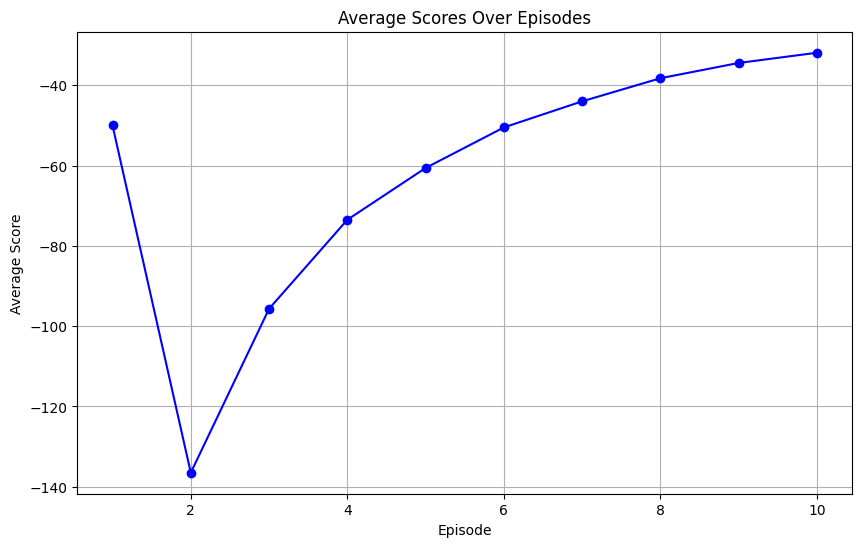

In [86]:
# plot the average score per episode
import matplotlib.pyplot as plt

episodes = list(range(1, n_games + 1))

plt.figure(figsize=(10, 6))
plt.plot(episodes, avg_scores_dqn, marker='o', linestyle='-', color='b', label='Average Score per Episode')
plt.title('Average Scores Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()


# Double DQN

In [87]:

import gym 
import gym_examples
from doubledqn import Agent
import numpy as np

env = gym.make('gym_examples/GridWorld-v0', size=4)
agent = Agent(gamma=0.9, epsilon=0.5, batch_size=10, n_actions=4, eps_end=0.01, input_dims=[16], lr=0.003, update_freq=50)
scores, eps_hist,avg_scores_ddqn = [], [], []
n_games = 10

for i in range(10):
    score = 0
    done=False
    observation = env.reset()[0]['agent']
    counter = 0

    while not done:
        agent_location = env.get_agent_location()
        print(f"Agent's Location: {agent_location}")

        # choose an action based on current state of env
        action = agent.choose_action(observation)

        observation_, reward, done, truncated, info = env.step(action)
        observation_ = observation_['agent'] # since one hot encoded state is nested in dictionary

        score += reward

        # store transition and update weights
        agent.store_transitions(observation, action, reward, observation_, done)
        agent.learn()

        #update state
        observation = observation_
        
        # end of an episode
        counter += 1
        print('---')

    scores.append(score)
    eps_hist.append(agent.epsilon)
    print('end game')

    avg_score = np.mean(scores)
    
    avg_scores_ddqn.append(avg_score)
    


Agent's Location: [3 0]
randomly selected action: 1
---
Agent's Location: [3 1]
randomly selected action: 0
---
Agent's Location: [3 1]
randomly selected action: 1
---
Agent's Location: [3 2]
randomly selected action: 3
---
Agent's Location: [3 1]
state: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
four actions: tensor([ 0.0718, -0.0247, -0.0428,  0.0398], grad_fn=<ViewBackward0>)
selected action: 0
---
Agent's Location: [3 1]
randomly selected action: 2
---
Agent's Location: [2 1]
randomly selected action: 1
---
Agent's Location: [2 2]
randomly selected action: 0
---
Agent's Location: [3 2]
state: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
four actions: tensor([ 0.0645, -0.0381, -0.0419,  0.1146], grad_fn=<ViewBackward0>)
selected action: 3
---
Agent's Location: [3 1]
randomly selected action: 1
---
Agent's Location: [3 2]
randomly selected action: 1
---
Agent's Location: [3 3]
state: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [88]:
np.mean(avg_scores_ddqn)

-148.01809523809527

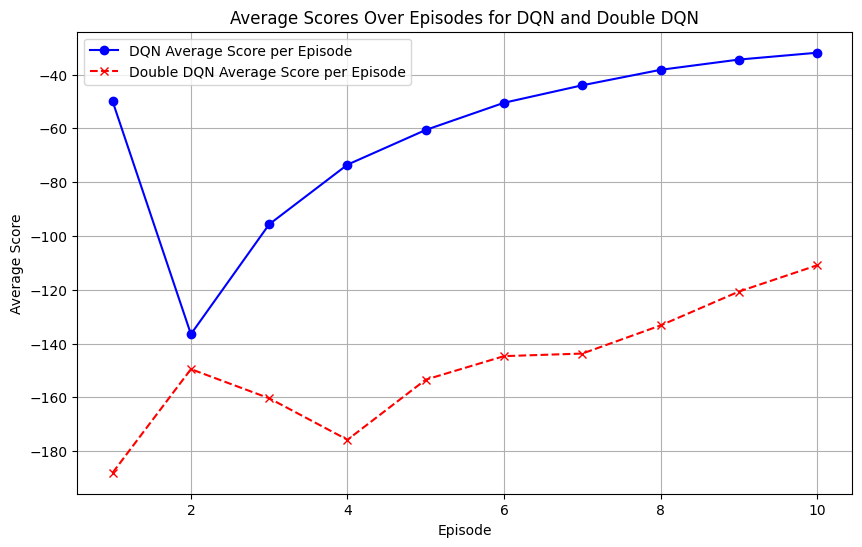

In [89]:
import matplotlib.pyplot as plt

# Assuming you've run both your DQN and Double DQN for the same number of episodes
episodes = list(range(1, n_games + 1))

plt.figure(figsize=(10, 6))

# Plot for regular DQN
plt.plot(episodes, avg_scores_dqn, marker='o', linestyle='-', color='b', label='DQN Average Score per Episode')

# Plot for Double DQN
plt.plot(episodes, avg_scores_ddqn, marker='x', linestyle='--', color='r', label='Double DQN Average Score per Episode')

plt.title('Average Scores Over Episodes for DQN and Double DQN')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.legend()  # This ensures the label for each line is shown
plt.grid(True)
plt.show()


In [90]:
scores

[-188, -111, -182, -222, -64, -101, -138, -60, -20, -23]